In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

[Learn the Basics](intro.html) \|\| **Quickstart** \|\|
[Tensors](tensorqs_tutorial.html) \|\| [Datasets &
DataLoaders](data_tutorial.html) \|\|
[Transforms](transforms_tutorial.html) \|\| [Build
Model](buildmodel_tutorial.html) \|\|
[Autograd](autogradqs_tutorial.html) \|\|
[Optimization](optimization_tutorial.html) \|\| [Save & Load
Model](saveloadrun_tutorial.html)

Quickstart
==========

This section runs through the API for common tasks in machine learning.
Refer to the links in each section to dive deeper.

Working with data
-----------------

PyTorch has two [primitives to work with
data](https://pytorch.org/docs/stable/data.html):
`torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. `Dataset`
stores the samples and their corresponding labels, and `DataLoader`
wraps an iterable around the `Dataset`.


In [60]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


torch.__version__

'2.6.0+cu118'

PyTorch offers domain-specific libraries such as
[TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and
[TorchAudio](https://pytorch.org/audio/stable/index.html), all of which
include datasets. For this tutorial, we will be using a TorchVision
dataset.

The `torchvision.datasets` module contains `Dataset` objects for many
real-world vision data like CIFAR, COCO ([full list
here](https://pytorch.org/vision/stable/datasets.html)). In this
tutorial, we use the FashionMNIST dataset. Every TorchVision `Dataset`
includes two arguments: `transform` and `target_transform` to modify the
samples and labels respectively.


In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)



We pass the `Dataset` as an argument to `DataLoader`. This wraps an
iterable over our dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading. Here we define a batch size of
64, i.e. each element in the dataloader iterable will return a batch of
64 features and labels.


In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Read more about [loading data in PyTorch](data_tutorial.html).


------------------------------------------------------------------------


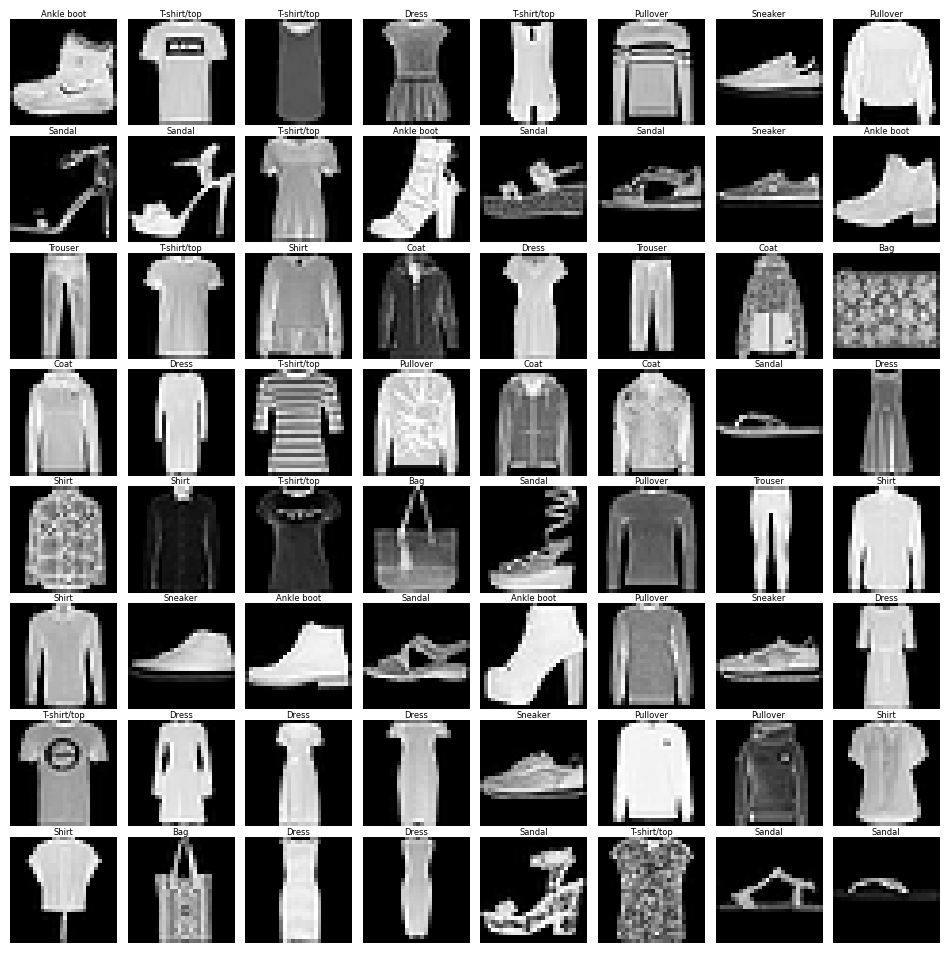

In [24]:
classes = training_data.classes

data_iter = iter(train_dataloader)
images, labels = next(data_iter)

fig, axes = plt.subplots(8, 8, figsize=(12, 12))

# 调整子图间距，使图片更加紧凑
plt.subplots_adjust(wspace=0.1, hspace=0.1)


for i, ax in enumerate(axes.flat):
    img = images[i].squeeze()  # 去掉通道维度
    label = labels[i].item()  # 获取类别索引
    
    ax.imshow(img, cmap="gray")
    ax.axis("off")
    ax.set_title(classes[label], fontsize=6, pad=2)

plt.show()

Creating Models
===============

To define a neural network in PyTorch, we create a class that inherits
from
[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
We define the layers of the network in the `__init__` function and
specify how data will pass through the network in the `forward`
function. To accelerate operations in the neural network, we move it to
the
[accelerator](https://pytorch.org/docs/stable/torch.html#accelerators)
such as CUDA, MPS, MTIA, or XPU. If the current accelerator is
available, we will use it. Otherwise, we use the CPU.


In [4]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Read more about [building neural networks in
PyTorch](buildmodel_tutorial.html).


------------------------------------------------------------------------


Optimizing the Model Parameters
===============================

To train a model, we need a [loss
function](https://pytorch.org/docs/stable/nn.html#loss-functions) and an
[optimizer](https://pytorch.org/docs/stable/optim.html).


In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-3, momentum=0.9)

In a single training loop, the model makes predictions on the training
dataset (fed to it in batches), and backpropagates the prediction error
to adjust the model\'s parameters.


In [106]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()        # 反向传播，计算当前梯度
        optimizer.step()       # 根据梯度更新网络参数
        optimizer.zero_grad()  # 清空过往梯度

        if batch % 200 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model\'s performance against the test dataset to
ensure it is learning.


In [26]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*).
During each epoch, the model learns parameters to make better
predictions. We print the model\'s accuracy and loss at each epoch;
we\'d like to see the accuracy increase and the loss decrease with every
epoch.


In [29]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.304499  [   64/60000]
loss: 2.293117  [ 6464/60000]
loss: 2.283215  [12864/60000]
loss: 2.287015  [19264/60000]
loss: 2.263138  [25664/60000]
loss: 2.229943  [32064/60000]
loss: 2.245785  [38464/60000]
loss: 2.207321  [44864/60000]
loss: 2.205698  [51264/60000]
loss: 2.176984  [57664/60000]
Test Error: 
 Accuracy: 36.9%, Avg loss: 2.177083 

Epoch 2
-------------------------------
loss: 2.182513  [   64/60000]
loss: 2.172021  [ 6464/60000]
loss: 2.126357  [12864/60000]
loss: 2.146805  [19264/60000]
loss: 2.098894  [25664/60000]
loss: 2.034036  [32064/60000]
loss: 2.071436  [38464/60000]
loss: 1.992366  [44864/60000]
loss: 1.998959  [51264/60000]
loss: 1.920990  [57664/60000]
Test Error: 
 Accuracy: 53.2%, Avg loss: 1.929052 

Epoch 3
-------------------------------
loss: 1.962249  [   64/60000]
loss: 1.926539  [ 6464/60000]
loss: 1.822822  [12864/60000]
loss: 1.860000  [19264/60000]
loss: 1.758681  [25664/60000]
loss: 1.696512  [32064/600

Read more about [Training your model](optimization_tutorial.html).


------------------------------------------------------------------------


Saving Models
=============

A common way to save a model is to serialize the internal state
dictionary (containing the model parameters).


In [31]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Loading Models
==============

The process for loading a model includes re-creating the model structure
and loading the state dictionary into it.


In [32]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

This model can now be used to make predictions.


In [33]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


images[i].size()=torch.Size([1, 28, 28]), img.size()=torch.Size([28, 28])


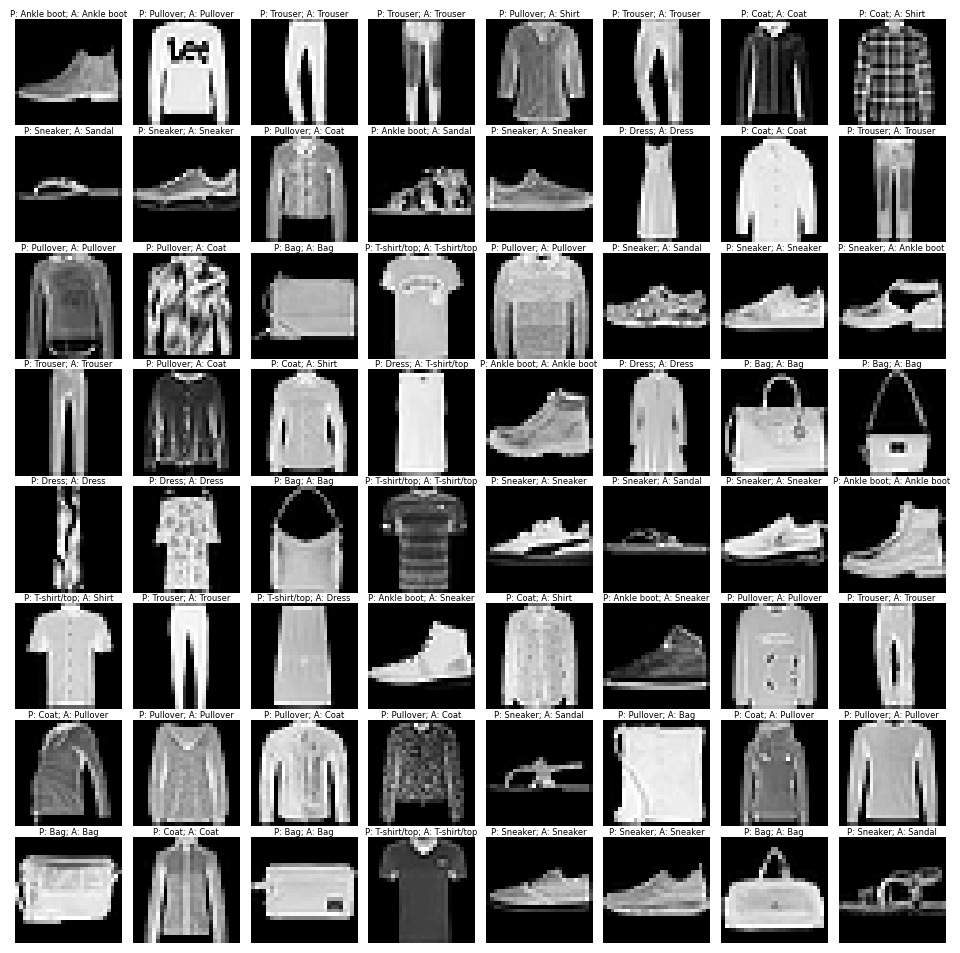

In [59]:
classes = test_data.classes

data_iter = iter(test_dataloader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

model.eval()
# 使用模型进行预测
with torch.no_grad():
    predictions = model(images)
    predicted_labels = predictions.argmax(dim=1)

fig, axes = plt.subplots(8, 8, figsize=(12, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i, ax in enumerate(axes.flat):
    img = images[i].cpu().squeeze()  # 去掉通道维度
    if i==0: print(f'images[i].size()={images[i].size()}, img.size()={img.size()}')
    actual_label = labels[i].item()  # 获取实际类别
    predicted_label = predicted_labels[i].item()  # 获取预测类别
    
    ax.imshow(img, cmap="gray")
    ax.axis("off")
    ax.set_title(f"P: {classes[predicted_label]}; A: {classes[actual_label]}", fontsize=6, pad=2)
    
plt.show()

# 模型优化
## [LeNet5](https://www.jiqizhixin.com/graph/technologies/6c9baf12-1a32-4c53-8217-8c9f69bd011b)

LeNet5诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。LeNet5通过巧妙的设计，利用卷积、参数共享、池化等操作提取特征，避免了大量的计算成本，最后再使用全连接神经网络进行分类识别，这个网络也是最近大量神经网络架构的起点。其结果图如下：



In [109]:
class LeNet(nn.Module):
    def __init__(self, in_dim=1, n_class=10):
        super(LeNet, self).__init__()    

        self.c1 = nn.Conv2d(in_channels=in_dim, out_channels=6, kernel_size=5, padding=2)
        self.s2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.s4 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.c5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5) 
        self.f6 = nn.Linear(120, 84)
        self.output = nn.Linear(84, n_class)    

        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.activation(self.c1(x))
        x = self.s2(x)
        x = self.activation(self.c3(x))
        x = self.s4(x) 
        x = self.c5(x)
        x = nn.Flatten()(x)
        x = self.f6(x)
        x = self.output(x)
        return x

model = LeNet(in_dim=1, n_class=10).to(device)
print(model)        

LeNet(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (s2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (c5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=10, bias=True)
  (activation): ReLU()
)


In [110]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-3, momentum=0.9)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302385  [   64/60000]
loss: 2.299879  [12864/60000]
loss: 2.291434  [25664/60000]
loss: 2.195447  [38464/60000]
loss: 1.035681  [51264/60000]
Test Error: 
 Accuracy: 67.5%, Avg loss: 0.863653 

Epoch 2
-------------------------------
loss: 0.911086  [   64/60000]
loss: 0.624696  [12864/60000]
loss: 0.806474  [25664/60000]
loss: 0.747288  [38464/60000]
loss: 0.680446  [51264/60000]
Test Error: 
 Accuracy: 73.5%, Avg loss: 0.710446 

Epoch 3
-------------------------------
loss: 0.623589  [   64/60000]
loss: 0.508874  [12864/60000]
loss: 0.701150  [25664/60000]
loss: 0.696133  [38464/60000]
loss: 0.663340  [51264/60000]
Test Error: 
 Accuracy: 76.3%, Avg loss: 0.645924 

Epoch 4
-------------------------------
loss: 0.537475  [   64/60000]
loss: 0.471433  [12864/60000]
loss: 0.706576  [25664/60000]
loss: 0.639292  [38464/60000]
loss: 0.624151  [51264/60000]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.611712 

Epoch 5
------------------------

Read more about [Saving & Loading your
model](saveloadrun_tutorial.html).
